# Vignette 2: Using multiple methods to infer the networks

Welcome to our second vignette! Here we assume you already know the basics of `Networkcommons`. If you don't, please check our [Introduction vignette](1_quickstart.html).

In this vignette, we will expand on the first one and perform network inference using several methods included in this package. We will start from the most simple, topological methods, to then move on to more complex ones, such as diffusion-like and integer-linear-programming based ones. You can find a more detailed description of the methods in the [dedicated section](../methods.html)

In [1]:
import networkcommons as nc
import pandas as pd

## 1. Loading preprocessed transcriptomics data

Like in the previous vignette, we will use a specific contrast from the [PANACEA](../datasets.html#panacea) (Afatinib versus DMSO in ASPC cell line) to extract the transcription factors that are dysregulated in this scenario.

In [2]:
dc_estimates = nc.data.omics.panacea_tables(cell_line='ASPC', drug='AFATINIB', type='TF_scores')
dc_estimates.set_index('items', inplace=True)
measurements = nc.utils.targetlayer_formatter(dc_estimates, act_col='act')

Now, we have our set of TF measurements, that encodes the effects of the drug-induced perturbation.

Afatinib targets EGFR by inhibition, so we will create a source dictionary containing the origin of perturbation, EGFR, and the sign of the perturbation (negative, therefore -1).

In [3]:
source_df = pd.DataFrame({'source': ['EGFR'], 
                          'sign': [-1]}, columns=['source', 'sign'])
source_df.set_index('source', inplace=True)
sources = source_df['sign'].to_dict()

## 2. Network inference

We have now our set of TF measurements, which we will use as footprints of the perturbation induced by Afatinib. We will use these to contextualised a general PPI network retrieved from OmniPath.

In [4]:
network = nc.data.network.get_omnipath()
graph = nc.utils.network_from_df(network)

Afatinib targets EGFR by inhibition, so we will create a source dictionary containing the origin of perturbation, EGFR, and the sign of the perturbation (negative, therefore -1).

In [5]:
source_df = pd.DataFrame({'source': ['EGFR'], 
                          'sign': [-1]}, columns=['source', 'sign'])
source_df.set_index('source', inplace=True)
sources = source_df['sign'].to_dict()

### 2.1 Topological methods: shortest paths, all paths

NetworkCommons also includes several topological methods. These methods follow very simple assumptions, and therefore are well suited to be compared against more advanced methodologies.

**Shortest paths**

This method retrieves the shortest path between source and target nodes. In the case where there are many paths with the same length, all these paths will be retrieved.

In [6]:
shortest_path_network, shortest_paths_list = nc.methods.run_shortest_paths(graph, sources, measurements)

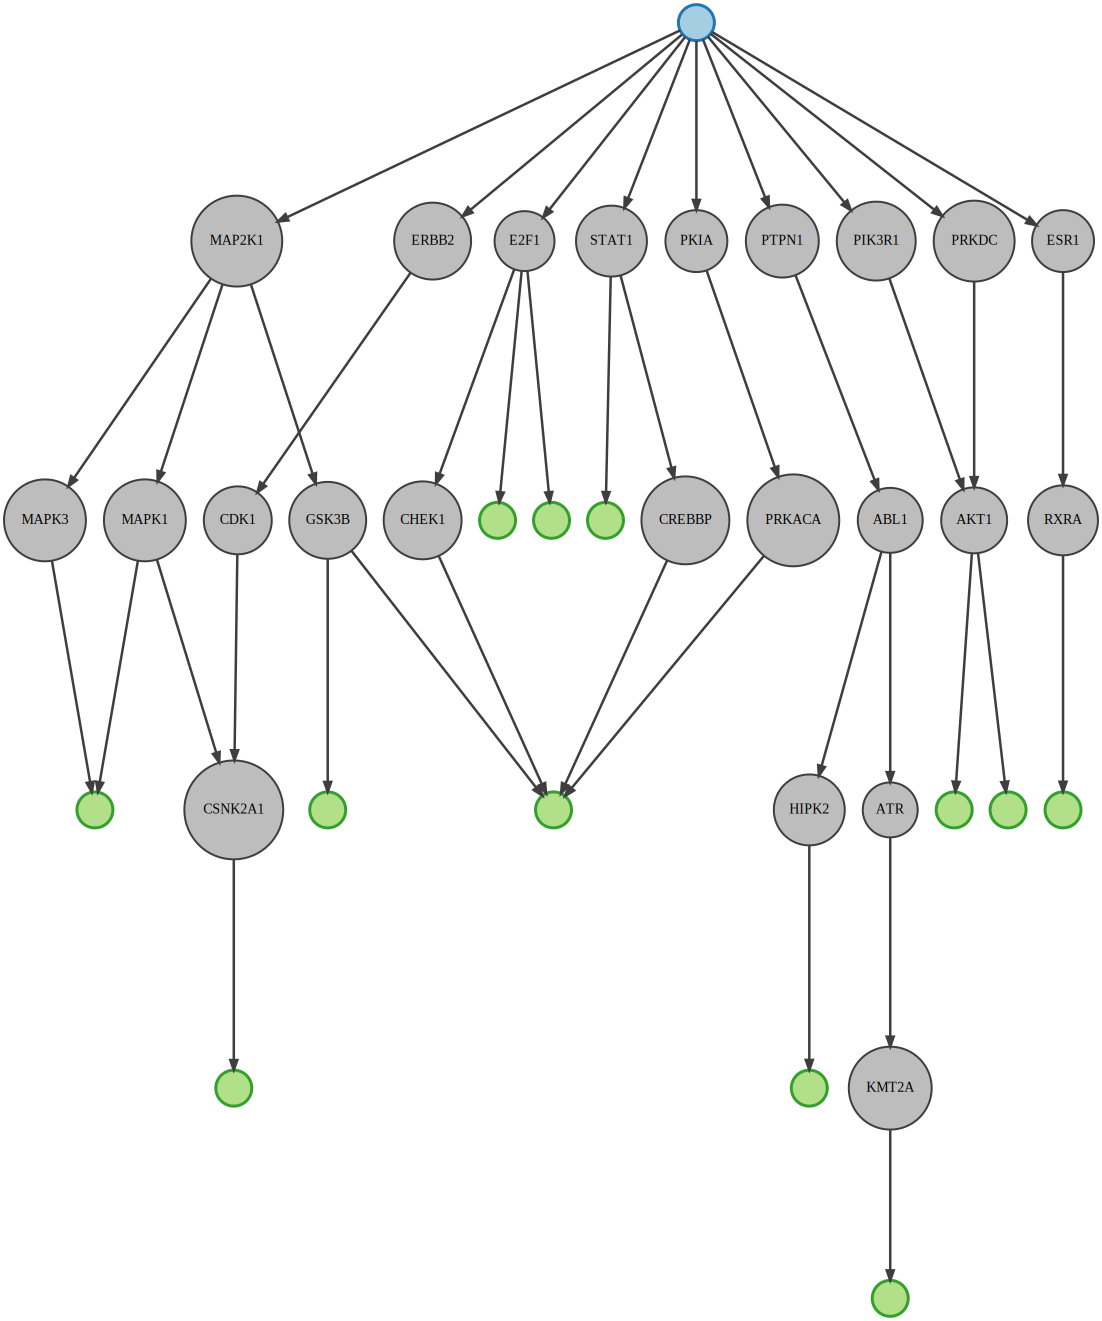

In [7]:
visualizer = nc.visual.NetworkXVisualizer(shortest_path_network)
visualizer.visualize_network(sources, measurements)

We can use the signs of the network to add an additional layer of constrain to the problem by removing the paths which are not coherent in terms of sign. The algorithm computes an overall sign of the path by multiplying the signs of the edges contained in said path, and then evaluates whether perturbation_sign * path_sign = measurement_sign. If it does not, the path is discarded.

In [8]:
shortest_sc_network, shortest_sc_list = nc.methods.run_sign_consistency(shortest_path_network, shortest_paths_list, sources, measurements)

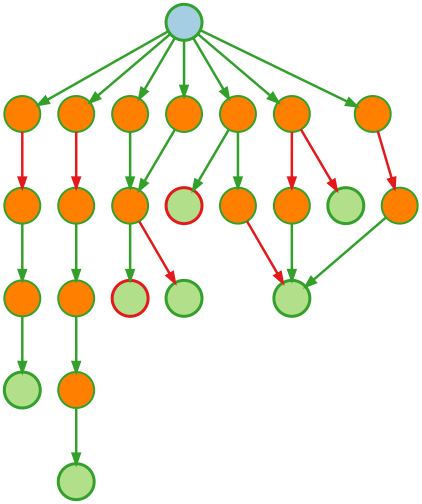

In [9]:
visualizer = nc.visual.NetworkXVisualizer(shortest_sc_network)
visualizer.visualize_network(sources, measurements, network_type='sign_consistent')

We used the measurements to select which paths we keep and which paths don't make sense, given our observed measurements. For cases in which we don't have a sign of a measurement, we can infer the signs by evaluating the agreement of the paths on the sign of the downstream measurement. For this, we must not provide the `run_sign_consistency()` function with a target dictionary. It will then infer the signs of the downstream layer and then return the dictionary with the inferred signs.

In [10]:
shortest_sc_network_inferred, shortest_sc_list_inferred, inferred_signs = nc.methods.run_sign_consistency(shortest_path_network, shortest_paths_list, sources)

No target sign provided. Inferring target signs by majority consensus.


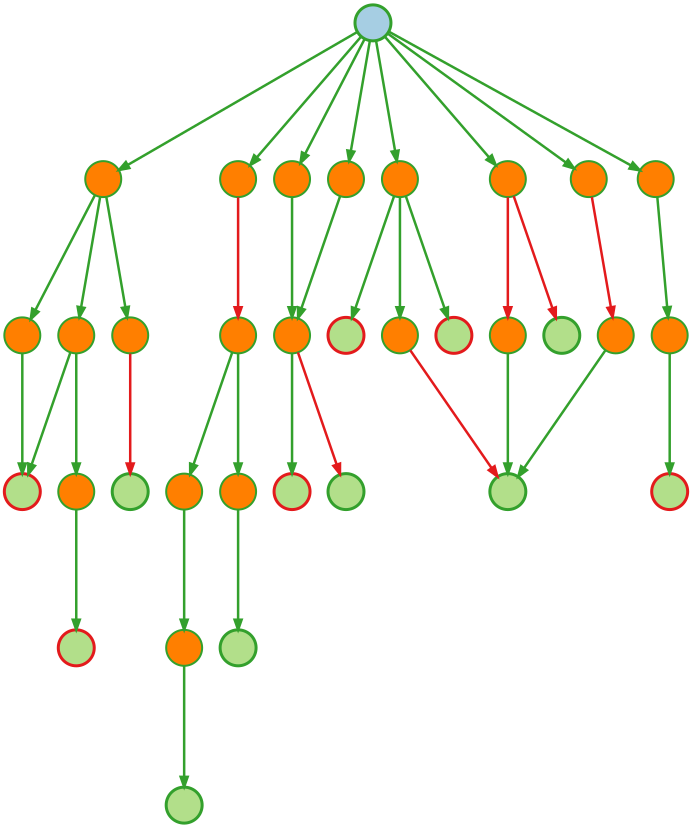

In [11]:
visualizer = nc.visual.NetworkXVisualizer(shortest_sc_network_inferred)
visualizer.visualize_network(sources, inferred_signs, network_type='sign_consistent')

**All paths**

As an alternative method, we can retrieve all possible paths (within a limit, due to computational constrains) between source and measurements layers. This might help us capture additional biological information which might not be available when considering more restrictive methods, such as shortest paths.

In [12]:
all_paths_network, all_paths_list = nc.methods.run_all_paths(graph, sources, measurements, depth_cutoff=3)

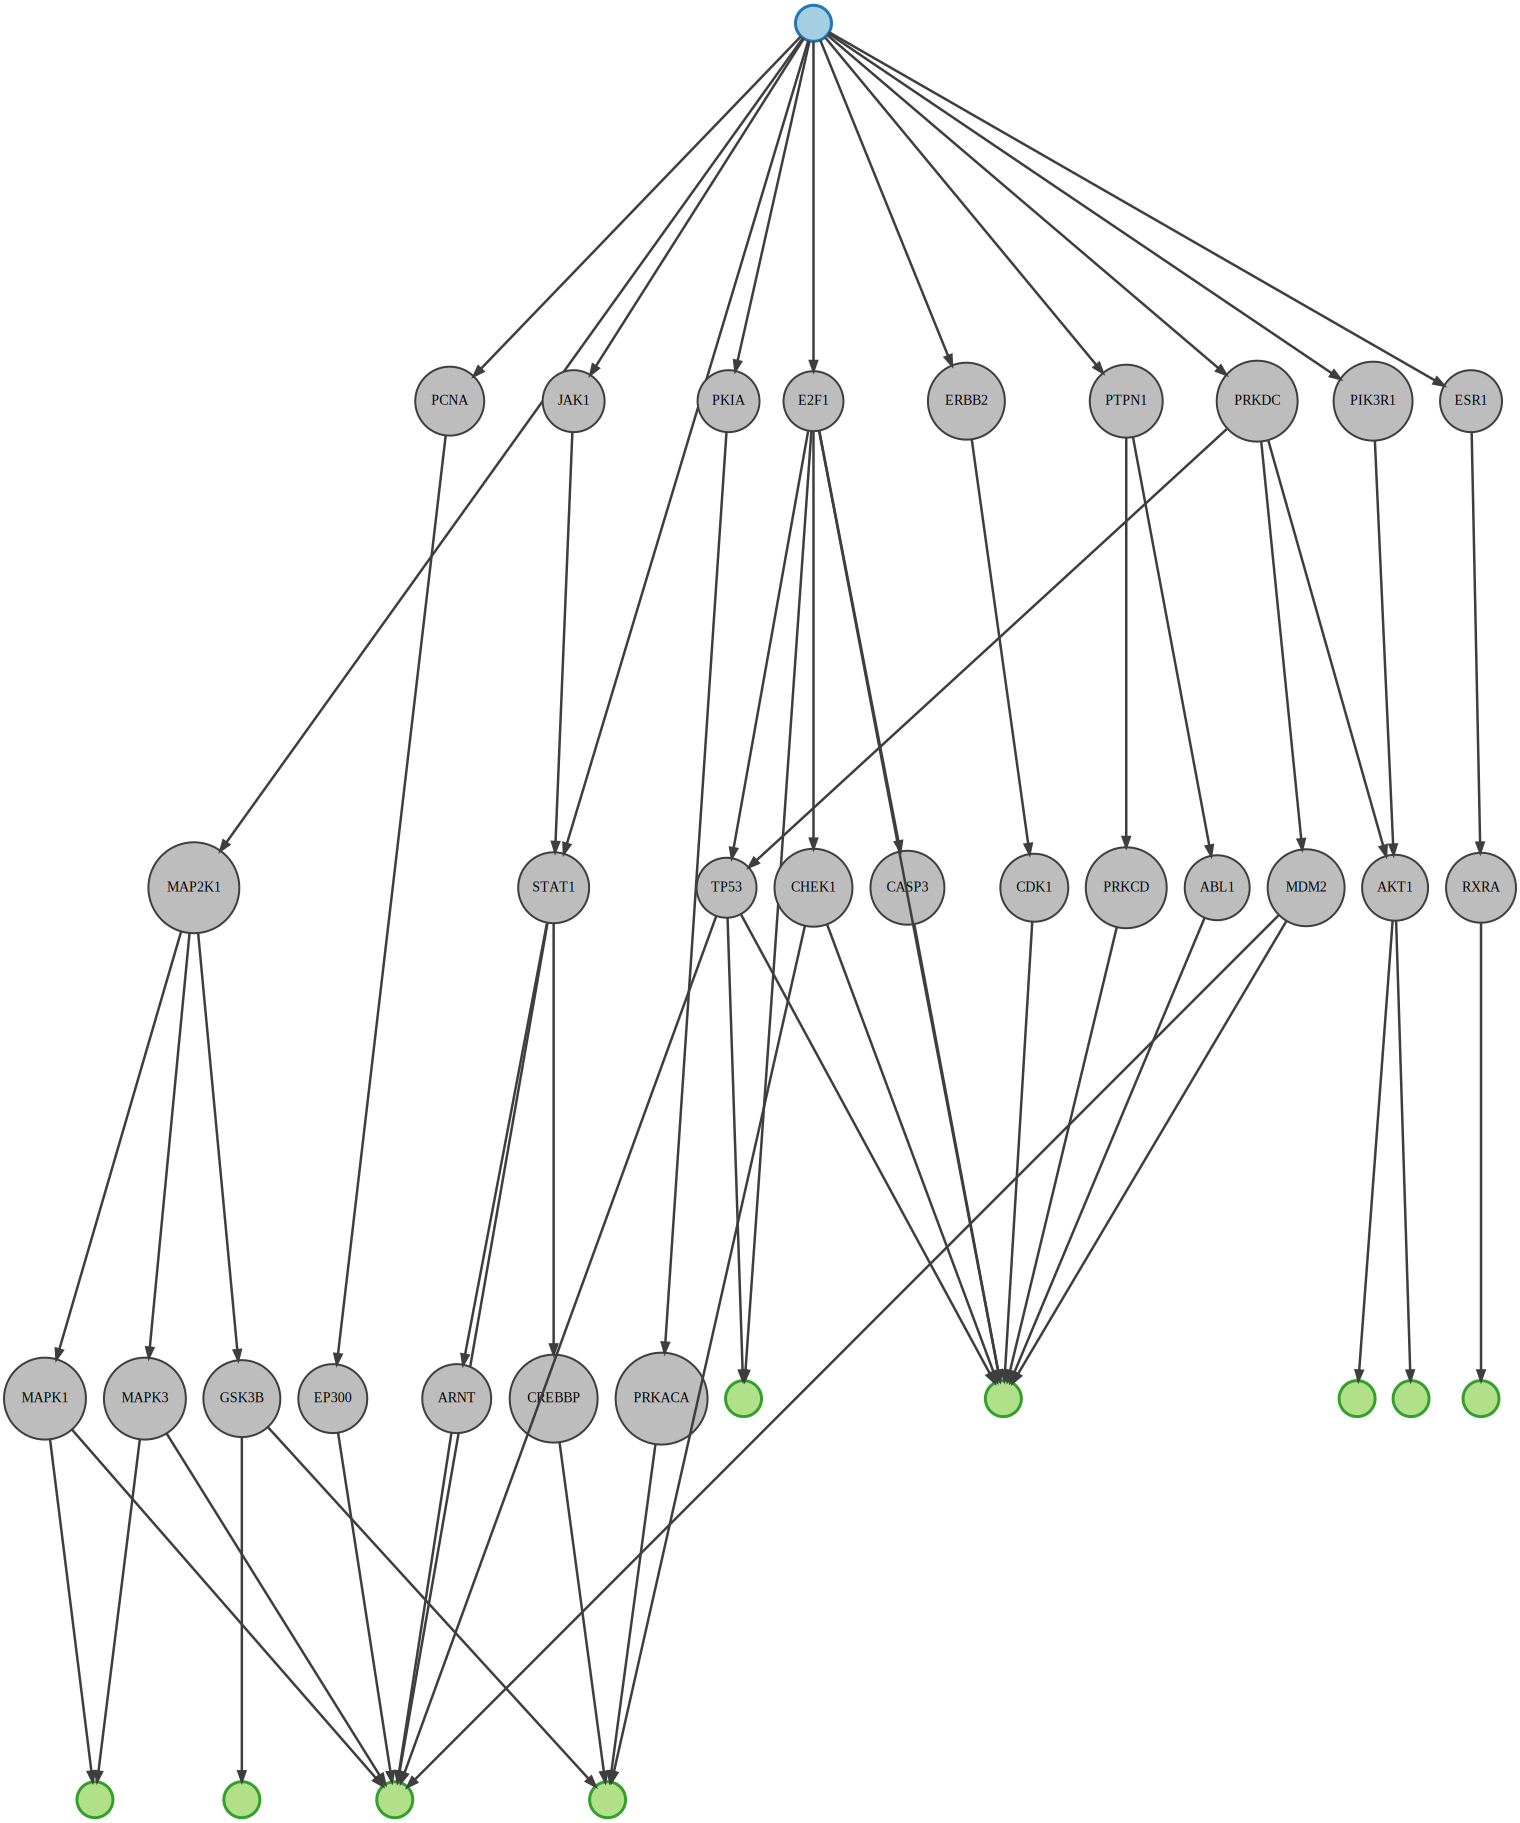

In [13]:
visualizer = nc.visual.NetworkXVisualizer(all_paths_network)
visualizer.visualize_network(sources, measurements)

Like in the previous case, we can apply an additional constrain by removing non-coherent paths in terms of signed interactions.

In [14]:
allpaths_sc_network, allpaths_sc_list = nc.methods.run_sign_consistency(all_paths_network, all_paths_list, sources, measurements)

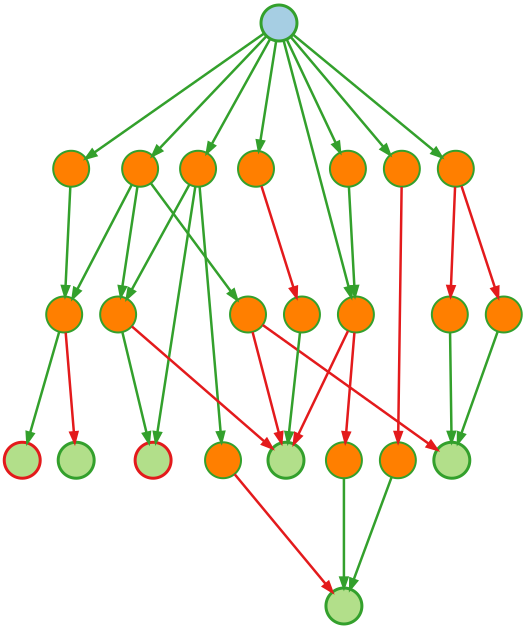

In [15]:
visualizer = nc.visual.NetworkXVisualizer(allpaths_sc_network)
visualizer.visualize_network(sources, measurements, network_type='sign_consistent')

### 2.2 Diffusion-like methods: Personalised PageRank

Several other methods follow a heat diffusion philosophy: "heat" propagates using the network topology and the "hottest" nodes are in the perturbation/measurement layers, cooling down the further away from these layers a node is.

In our approach, we use personalised PageRank (PPR), in which the probabilities of the random walker are altered, as a computationally inexpensive approach to this philosophy.

We compute PPR values starting from both perturbation and measurement layers, and then by applying a threshold (top % nodes with highest PPR value) we retrieve only the network which is most accessible from these two layers.

In [16]:
ppr_network = nc.methods.add_pagerank_scores(graph, sources, measurements, personalize_for='source')
ppr_network = nc.methods.add_pagerank_scores(ppr_network, sources, measurements, personalize_for='target')

ppr_network = nc.methods.compute_ppr_overlap(ppr_network, percentage=1)

Now, we can use a path-recover method, such as shortest paths or all paths, to retrieve a smaller subnetwork.

In [17]:
shortest_ppr_network, shortest_ppr_list = nc.methods.run_shortest_paths(ppr_network, sources, measurements)

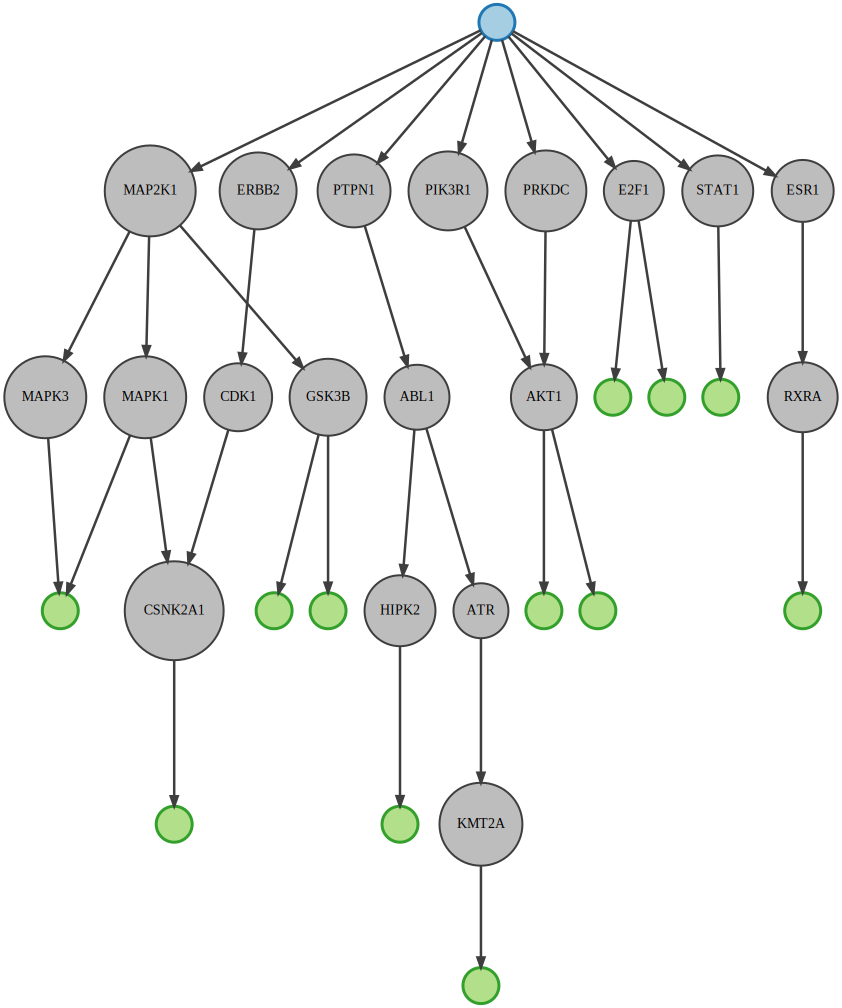

In [18]:
visualizer = nc.visual.NetworkXVisualizer(shortest_ppr_network)
visualizer.visualize_network(sources, measurements)

We can also add sign consistency checks:

In [19]:
shortest_sc_ppr_network, shortest_sc_ppr_list = nc.methods.run_sign_consistency(shortest_ppr_network, shortest_ppr_list, sources, measurements)

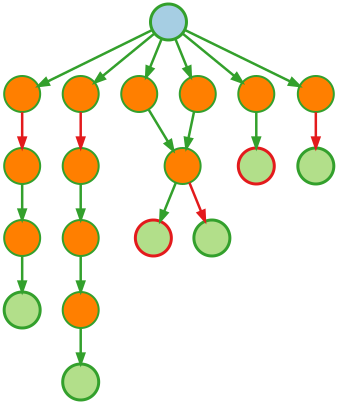

In [20]:
visualizer = nc.visual.NetworkXVisualizer(shortest_sc_ppr_network)
visualizer.visualize_network(sources, measurements, network_type='sign_consistent')

### 2.3 Integer linear programming: CORNETO

Last, we will use Carnival via CORNETO, which incorporates more advanced approaches. However, it is the most computationally expensive of all the methods included in `Networkcommons`. 

<div class="alert alert-warning">

**Warning**
    
This section of the tutorial uses CORNETO, a package specialised in Integer Linear programming for network inference. Some CORNETO methods (such as Carnival) depend on GUROBI, a third-party solver that holds a commercial license. Therefore, in order to run this part of the code, you will have to install a license in your system. Please check their home page for more information. 

</div>

In [ ]:
corneto_network = nc.methods.run_corneto_carnival(graph, sources, measurements, betaWeight=0.01, solver='GUROBI')

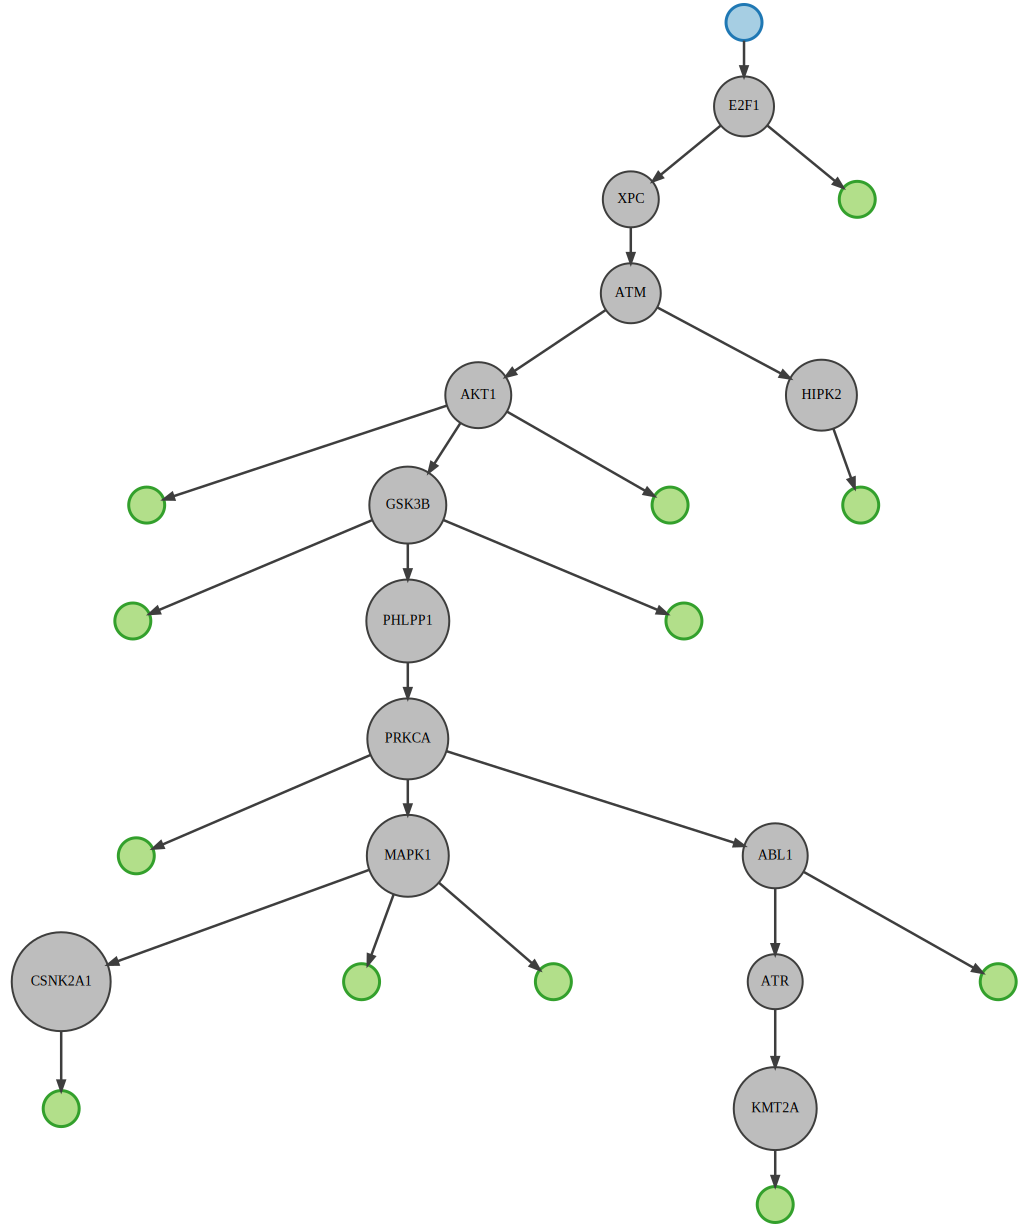

In [22]:
visualizer = nc.visual.NetworkXVisualizer(corneto_network)
visualizer.visualize_network(sources, measurements)

And we're done! As you can see, the networks look quite different depending on the methods used to contextualise the PKN. However, how do we know which one is the most "correct" one? In the next vignette, we will start exploring the last module in `Networkcommons` we have not talked about: **Evaluation**, where we will try out some strategies to evaluate the performance of the methods. See you soon!